In [59]:
import numpy as np
from torch import nn

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, test_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
import lib.torch_device as tdev
import torch.optim.lr_scheduler as lr_scheduler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [61]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69421)

In [62]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

correlated_columns_to_drop = array([  0,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214

In [63]:
data_train.shape

(960, 100, 264)

In [64]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 264)
(60, 100)


## Hyper Parameters

In [65]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_train.shape[-1],
    out_features=NUM_CLASSES,
    d_model=64,
    num_heads=8,
    stack_size=1,
    dropout=0.1,
    in_linear_hidden_out_features=[128],
    out_linear_hidden_out_features=[128],
    linear_activation_provider=lambda: nn.LeakyReLU(),
)

In [66]:
EPOCH_MULTIPLIER = 1

training_hyper_parameters = TrainingHyperParameters(
    batch_size=32,
    num_epochs=int(150 * EPOCH_MULTIPLIER),
    lr=5e-3,
    lr_scheduler_provider=lambda optimizer: lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[int(m * EPOCH_MULTIPLIER) for m in [20, 60, 100]],  # [10, 30, 60, 100]], 
        gamma=0.5
    )
)

## Training

In [67]:
set_random_seed(42)

cv_models = train_attention_classifier_with_cv(
    hyper_parameters, 
    training_hyper_parameters, 
    NumpyDataset(data_train, labels_train),
    device
)

Training fold 0
Training AttentionClassifier with 68039 parameters
loss_weight = tensor([ 1.0000, 15.8275,  9.6494, 10.6295, 36.9184, 17.7606, 19.8364],
       device='cuda:0')
Training Epoch 0  : lr = 0.005000, epoch_loss = 42.202817, num_correct = 13104, num_samples = 85536, acc = 0.153199, bacc = 0.332055
Evaluated with loss = 0.043911, acc = 0.328598, bacc = 0.583867
Training Epoch 1  : lr = 0.005000, epoch_loss = 23.993338, num_correct = 22511, num_samples = 85536, acc = 0.263176, bacc = 0.490375
Evaluated with loss = 0.004087, acc = 0.306082, bacc = 0.759157
Training Epoch 2  : lr = 0.005000, epoch_loss = 17.221240, num_correct = 25007, num_samples = 85536, acc = 0.292356, bacc = 0.583637
Evaluated with loss = 0.005539, acc = 0.319655, bacc = 0.750041
Training Epoch 3  : lr = 0.005000, epoch_loss = 14.737989, num_correct = 25822, num_samples = 85536, acc = 0.301885, bacc = 0.643599
Evaluated with loss = 0.003549, acc = 0.345644, bacc = 0.778425
Training Epoch 4  : lr = 0.005000, 

KeyboardInterrupt: 

Training AttentionClassifier with 68039 parameters
loss_weight = tensor([ 1.0000, 15.3204,  9.3547, 10.4259, 36.4963, 17.9374, 19.6462],
       device='cuda:0')
Training Epoch 0  : lr = 0.005000, epoch_loss = 61.057405, num_correct = 17172, num_samples = 95040, acc = 0.180682, bacc = 0.227976
Training Epoch 1  : lr = 0.005000, epoch_loss = 76.761902, num_correct =  2565, num_samples = 95040, acc = 0.026989, bacc = 0.150810
Training Epoch 2  : lr = 0.005000, epoch_loss = 70.233804, num_correct =  3614, num_samples = 95040, acc = 0.038026, bacc = 0.130356
Training Epoch 3  : lr = 0.005000, epoch_loss = 70.193547, num_correct =  5435, num_samples = 95040, acc = 0.057186, bacc = 0.145486
Training Epoch 4  : lr = 0.005000, epoch_loss = 70.291492, num_correct = 28746, num_samples = 95040, acc = 0.302462, bacc = 0.155497
Training Epoch 5  : lr = 0.005000, epoch_loss = 83.554285, num_correct =  1091, num_samples = 95040, acc = 0.011479, bacc = 0.129964
Training Epoch 6  : lr = 0.005000, epoch_

<Figure size 1440x1440 with 0 Axes>

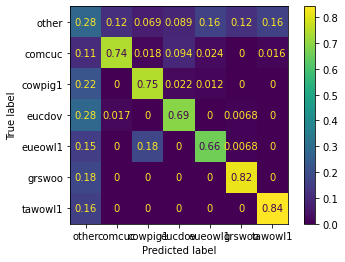

In [68]:
set_random_seed(4354)

data_train_normalized, data_test_normalized = normalize_data(data_train, data_test)

attention_classifier = train_attention_classifier(
    hyper_parameters, 
    training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    None,
    device
)

# test_loader = create_data_loader(np.random.normal(size=(240, 100, 268)), np.random.randint(0, 7, size=(240, 100)))
test_loader = create_data_loader(data_test_normalized, labels_test)
test_attention_classifier(attention_classifier, test_loader, device)

In [35]:
# load_model('attention_classifier fold-1')
# TODO: normalization
test_loader = create_data_loader(data_test_normalized, labels_test)
test_attention_classifier(load_model('cv1/attention_classifier fold-0'), test_loader, device)

NameError: name 'data_test_normalized' is not defined